<a href="https://colab.research.google.com/github/mt-cs/statistics-of-ai/blob/main/AI_Recommendation_System1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Building a Collaborative Filtering Recommendation System Using MovieLens Data

Data Exploration, Preprocessing, and Initial Model Development

Authors: Marisa Tania, Navya Sugandham

In [ ]:
!pip install scikit-surprise


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 4.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.4-cp312-cp312-linux_x86_64.whl size=2554983 sha256=2c1071344dc5f1690ef9599eae312be4621148cd44c04e5ed755058d6cd3994e
  Stored in directory: /root/.cache/pip/wheels/75/fa/bc/739bc2cb1fbaab6061854e6cfbb81a0ae52c92a502a7fa454b
Successfully built scikit-surprise


In [ ]:
!pip install numpy==1.26.4


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from surprise import Dataset, Reader, SVD, accuracy
from surprise.model_selection import train_test_split


# 1. Understanding Recommendation Systems

Recommendation systems aim to predict which **items** (e.g., movies) a **user** will like based on past behavior.

## Collaborative Filtering (this project)
Collaborative filtering uses **user–item interactions** (ratings) to make recommendations.

- **User-based CF:** recommend items liked by *similar users*.
- **Item-based CF:** recommend items similar to what the user already liked.

**Key assumption:** if users agreed in the past, they are likely to agree in the future.

## Content-Based Filtering (contrast)
Content-based filtering recommends items based on **item attributes** (genre, cast, keywords) and a user’s profile.
It does **not** require other users’ ratings, but it depends on having reliable item metadata.

In this notebook, we build a collaborative filtering baseline using **matrix factorization (SVD)**.

In [ ]:
# Load MovieLens 100k dataset from Surprise
data = Dataset.load_builtin('ml-100k')

# Confirm dataset loaded
print("MovieLens 100k dataset loaded successfully")


Dataset ml-100k could not be found. Do you want to download it? [Y/n] Y
Trying to download dataset from https://files.grouplens.org/datasets/movielens/ml-100k.zip...
Done! Dataset ml-100k has been saved to /root/.surprise_data/ml-100k
MovieLens 100k dataset loaded successfully


# 2. Data Exploration and Preprocessing

We inspect the dataset, check for missing values and duplicates, and visualize rating behavior
(e.g., rating distribution, ratings per user, ratings per movie). These steps help identify sparsity
and potential biases that can affect recommendation quality.


The dataset includes:
1. user_id: Unique identifier for users
2. item_id: Unique identifier for items (e.g., movies).
3. rating: Rating given by the user to the item (usually between 1 and 5).

In [ ]:
raw_ratings = data.raw_ratings

df = pd.DataFrame(raw_ratings, columns=['user_id', 'item_id', 'rating', 'timestamp'])
df = df.drop(columns=['timestamp'])

df.head()


,user_id,item_id,rating
0,196,242,3.0
1,186,302,3.0
2,22,377,1.0
3,244,51,2.0
4,166,346,1.0


In [ ]:
df.shape


(100000, 3)

In [ ]:
print(df.info())
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   user_id  100000 non-null  int64  
 1   item_id  100000 non-null  int64  
 2   rating   100000 non-null  float64
dtypes: float64(1), int64(2)
memory usage: 2.3 MB
None
            user_id        item_id         rating
count  100000.00000  100000.000000  100000.000000
mean      462.48475     425.530130       3.529860
std       266.61442     330.798356       1.125674
min         1.00000       1.000000       1.000000
25%       254.00000     175.000000       3.000000
50%       447.00000     322.000000       4.000000
75%       682.00000     631.000000       4.000000
max       943.00000    1682.000000       5.000000


In [ ]:
df.isnull().sum()


,0
user_id,0
item_id,0
rating,0


In [ ]:
df.duplicated().sum()


0

In [ ]:
df = df.drop_duplicates()
df = df.dropna()

df.shape


(100000, 3)

In [ ]:
# Validate ratings
df = df[(df['rating'] >= 1) & (df['rating'] <= 5)]

In [ ]:
# Check sparsity
n_users = df['user_id'].nunique()
n_items = df['item_id'].nunique()
n_ratings = len(df)

sparsity = 1 - (n_ratings / (n_users * n_items))

print(f"Users: {n_users}")
print(f"Items: {n_items}")
print(f"Ratings: {n_ratings}")
print(f"Sparsity: {sparsity:.4f}")

Users: 943
Items: 1682
Ratings: 100000
Sparsity: 0.9370


In [ ]:
# Remove extremely inactive users/items
min_user_ratings = 3
min_item_ratings = 3

user_counts = df['user_id'].value_counts()
item_counts = df['item_id'].value_counts()

df = df[df['user_id'].isin(user_counts[user_counts >= min_user_ratings].index)]
df = df[df['item_id'].isin(item_counts[item_counts >= min_item_ratings].index)]
df.shape

(99723, 3)

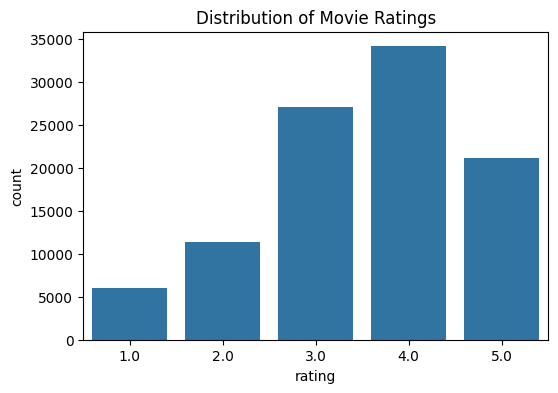

In [ ]:
plt.figure(figsize=(6,4))
sns.countplot(x='rating', data=df)
plt.title("Distribution of Movie Ratings")
plt.show()


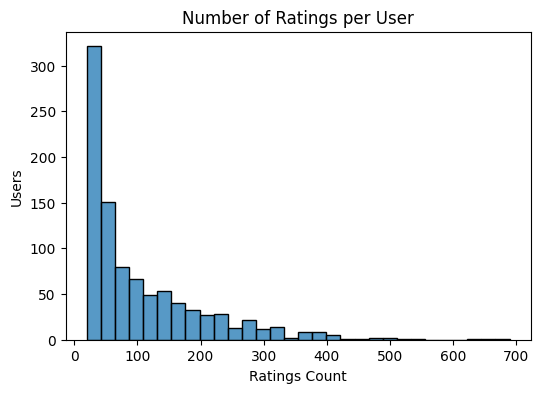

In [ ]:
ratings_per_user = df.groupby('user_id')['rating'].count()

plt.figure(figsize=(6,4))
sns.histplot(ratings_per_user, bins=30)
plt.title("Number of Ratings per User")
plt.xlabel("Ratings Count")
plt.ylabel("Users")
plt.show()


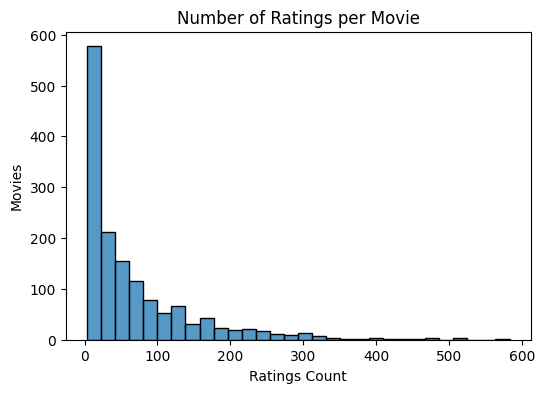

In [ ]:
ratings_per_movie = df.groupby('item_id')['rating'].count()

plt.figure(figsize=(6,4))
sns.histplot(ratings_per_movie, bins=30)
plt.title("Number of Ratings per Movie")
plt.xlabel("Ratings Count")
plt.ylabel("Movies")
plt.show()


In [39]:
# Define rating scale
reader = Reader(rating_scale=(1, 5))

# Load data into Surprise format
data_surprise = Dataset.load_from_df(
    df[['user_id', 'item_id', 'rating']],
    reader
)


# 3. Data Splitting

We split the dataset into **training** and **testing** sets. The model learns from the training set and is evaluated on the test set.


In [40]:
from surprise.model_selection import train_test_split

trainset, testset = train_test_split(data_surprise, test_size=0.25, random_state=42)

print("Train-test split completed")


Train-test split completed


# 4. Model Selection: SVD Collaborative Filtering

We start with **SVD (Singular Value Decomposition)**, a matrix factorization method that learns latent user and item factors.
This is a strong baseline for rating prediction tasks.


In [ ]:
model = SVD()
model.fit(trainset)

print("SVD model trained successfully")


SVD model trained successfully


# 5. Model Evaluation (RMSE)

We evaluate rating prediction accuracy using **Root Mean Squared Error (RMSE)**.
Lower RMSE indicates predicted ratings are closer to true user ratings.

In [41]:
predictions = model.test(testset)

rmse = accuracy.rmse(predictions)
print("RMSE:", rmse)


RMSE: 0.9365
RMSE: 0.936494862946378


# 6. Hyperparameter Tuning (Grid Search)

We tune SVD hyperparameters such as:
- `n_factors`: number of latent factors
- `n_epochs`: training iterations
- `lr_all`: learning rate
- `reg_all`: regularization strength

We use cross-validation (`cv=3`) and optimize for **RMSE**.


In [42]:
from surprise.model_selection import GridSearchCV

param_grid = {
    'n_factors': [50, 100],
    'n_epochs': [20, 40],
    'lr_all': [0.002, 0.005],
    'reg_all': [0.02, 0.1]
}

grid_search = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=3, n_jobs=-1)
grid_search.fit(data_surprise)

print("Best RMSE score:", grid_search.best_score['rmse'])
print("Best params:", grid_search.best_params['rmse'])

Best RMSE score: 0.9279000675181027
Best params: {'n_factors': 100, 'n_epochs': 40, 'lr_all': 0.005, 'reg_all': 0.1}


# 7. Train Best Model and Generate Top-N Recommendations

After tuning, we retrain SVD using the best hyperparameters on the training set, evaluate RMSE on the test set,
then generate **Top-N** recommendations by predicting ratings for items the user has not rated (the *anti-testset*).

In [ ]:
best_params = grid_search.best_params['rmse']
best_model = SVD(**best_params)
best_model.fit(trainset)

best_predictions = best_model.test(testset)
best_rmse = accuracy.rmse(best_predictions)
print("Test RMSE (best SVD):", best_rmse)

RMSE: 0.9245
Test RMSE (best SVD): 0.9245387614317754


In [ ]:
def get_top_n(predictions, n=10):
    top_n = {}

    for uid, iid, true_r, est, _ in predictions:
        top_n.setdefault(uid, []).append((iid, est))

    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

# Build anti-testset: all user-item pairs NOT in the training data
anti_testset = trainset.build_anti_testset()
anti_predictions = best_model.test(anti_testset)

top_n = get_top_n(anti_predictions, n=10)

# Show Top-10 recommendations for a few users
for uid in list(top_n.keys())[:5]:
    print(f"User {uid} top-10 recommendations (item_id, predicted_rating):")
    print(top_n[uid])
    print("-" * 60)


User 877 top-10 recommendations (item_id, predicted_rating):
[('318', 4.538794471621166), ('64', 4.476310383351522), ('483', 4.473776497745257), ('1449', 4.454757227322837), ('178', 4.421583316140676), ('513', 4.415271788342846), ('408', 4.406134945835544), ('251', 4.372061962927293), ('50', 4.358234379217512), ('98', 4.354783064157844)]
------------------------------------------------------------
User 815 top-10 recommendations (item_id, predicted_rating):
[('1449', 4.616696902246321), ('313', 4.6027057376200595), ('64', 4.602302609958551), ('408', 4.503626111013422), ('174', 4.499513706492901), ('178', 4.497708773698949), ('657', 4.47614650831651), ('22', 4.431640295733291), ('1131', 4.430292725759122), ('496', 4.393132780813584)]
------------------------------------------------------------
User 94 top-10 recommendations (item_id, predicted_rating):
[('408', 4.81930389114915), ('285', 4.650391071521401), ('127', 4.64738004576458), ('169', 4.626598865018544), ('100', 4.625790289806077

# 8. Ethical Considerations

Recommendation systems can create real-world impacts. Key concerns include:

- **Bias & popularity effects:** Models can over-recommend popular items and under-represent niche content (*long-tail suppression*).
- **Filter bubbles:** Personalization may reduce exposure to diverse viewpoints or content.
- **Privacy:** User behavior data can be sensitive; minimize collection, restrict access, and avoid re-identification risks.
- **Transparency:** Users should understand that recommendations are algorithmic and based on prior interactions.
- **Fairness:** If demographic attributes exist, evaluate whether certain groups receive systematically lower-quality recommendations.

In this dataset, we do not have explicit demographic features, but we can still monitor for popularity bias (ratings per movie)
and examine whether recommendations concentrate on a small set of highly-rated items.

